# Capstone Project: The Battle of Neighborhoods
## Final Capstone Assignment for IBM Data Science Coursera 

## Introduction
New York City is the most popululated American city with over 8 million residents. NYC is a melting pot of people from all aroud the world, not only does the city have a diverse population but also a myriad of different ethnic cuisines. NYC was hit harshly by the pandemic which took the lives of thousands of New York City residents. But to remain strong the city must unite, as it always has, and the thing New Yorkers all have in common is their love for is pizza. 

In this project I will be exploring where to open a new pizza shop in New York City that will attract the most amount of New Yorkers. There are a lot of existing pizza restaurants already however I'm interested in exploring which neighborhoods lack pizza shops to see if a new shop could satisfy the local business need. However, many factors must be taken into consideration. In particular, the location of the restaurant is one of the most important factors that will affect my project. First I will need to answer the question of "Where are the best/most highly rated restaurants in NYC located?" and "What are some common features among these restaurants that makes them popular?" Lastly I will aim to answer the question of: “Where is there a need for a pizza restaurant in New York City?” 

## Data
In order to answer the above questions, I need data on New York City's neighborhoods, boroughs along with the latitude, longitude information of all the restaurants, and the restaurants' ratings and tips.

I will use the following data set that was provided to us in the Clustering and Segmenting lab that contains NYC information: https://cocl.us/new_york_dataset

I will use FourSquare API to obtain the location and rating infromation of existing pizza restauarnts in NYC

## Methodology
1. Clean and process data into a dataframe.
2. Call a FourSquare API to locate all Pizza restaurants. Ratings, tips, and likes will be merged to existing dataframe.
3. Data will be sorted based on rankings.
4. Data will be presented via data visualisation tools in Python and Folium package

## Problem Statement
What are the best Pizza places in NYC? What is / are the best location(s) for opening a new Pizza restaurant in New York City? 


## Load all required libraries


In [19]:

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


In [20]:
CLIENT_ID = 'C0E1OXUNTZH22LVI2DPHIRQH3CPYGST5PVOV54PKX2ZSYP0S' # your Foursquare ID
CLIENT_SECRET = 'EAU4PHUQFG5EC1040ZZBFPZHBD3AKNRSMJ02NQUFOJWXFVEP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Get NYC Data

In [135]:
def get_new_york_data():
    nyurl='https://cocl.us/new_york_dataset'
    resp=requests.get(nyurl).json()
    # get all data features
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
   
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data
print("all done")

all done


In [136]:
NYC_data = get_new_york_data()
NYC_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [137]:
NYC_data.shape

(306, 4)

Text(0, 0.5, '')

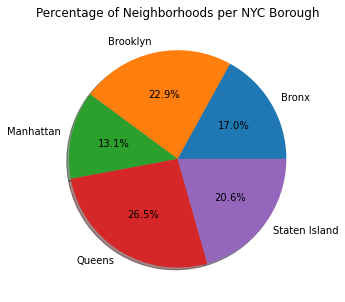

In [66]:
# Plot the NYC data to visualize how many Neighborhoods per Burough 
NYC_data.groupby('Borough')['Neighborhood'].count().plot(kind='pie',figsize=(10,5), autopct='%1.1f%%',shadow=True)
plt.title('Percentage of Neighborhoods per NYC Borough')
plt.ylabel('')

The pie chart shows that in descending order the number of neighborhoods per Borough is greatest in Queens, followed by Brooklyn, Staten Island, Bronx and finally Manhattan. 

Lets see how many pizza restrautns there are per Borough 

In [138]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']#['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [ ]:


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url2 = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df





In [139]:

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [119]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
pizza_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    pizza_restaurants=venues[venues['Category']=='Pizza']   
    print('(',count,'/',len(ny_data),')','Pizza Restaurants in '+Neighborhood+', '+Borough+':'+str(len(pizza_restaurants)))
    print(row)
    for resturant_detail in pizza_restaurants.values.tolist():
        id, name , category=resturant_detail
        pizza_rest_ny = pizza_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Pizza Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Pizza Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Pizza Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Pizza Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Pizza Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Pizza Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Pizza Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Pizza Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Pizza Restaurants in Norwood, Bronx:0
['Bronx', 'Norwood',

( 70 / 306 ) Pizza Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Pizza Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Pizza Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Pizza Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Pizza Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Pizza Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
( 76 / 306 ) Pizza Restaurants in Flatlands, Brooklyn:0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
( 77 / 306 ) Pizza Restaurants in Mill Island, Brooklyn:0
['Brooklyn', 'Mill Island', 40.606336421685626, -73.9081857177742

( 135 / 306 ) Pizza Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Pizza Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Pizza Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Pizza Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Pizza Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Pizza Restaurants in Long Island City, Queens:0
['Queens', 'Long Island City', 40.75021734610528, -73.93920223915505]
( 141 / 306 ) Pizza Restaurants in Sunnyside, Queens:0
['Queens', 'Sunnyside', 40.74017628351924, -73.92691617561577]
( 142 / 306 ) Pizza Restaurants in East Elmhurst, Queens:0
['Queens', 'East Elmhurst', 40.76407323883091, -73.86704147658772]
( 143 / 306 ) Pizza Resta

( 203 / 306 ) Pizza Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Pizza Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Pizza Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Pizza Restaurants in Port Richmond, Staten Island:0
['Staten Island', 'Port Richmond', 40.63366930554365, -74.12943426797008]
( 207 / 306 ) Pizza Restaurants in Mariner's Harbor, Staten Island:0
['Staten Island', "Mariner's Harbor", 40.632546390481124, -74.15008537046981]
( 208 / 306 ) Pizza Restaurants in Port Ivory, Staten Island:0
['Staten Island', 'Port Ivory', 40.63968297845542, -74.17464532993542]
( 209 / 306 ) Pizza Restaurants in Castleton Corners, Staten Island:0
['Staten Island', 'Castleton Corners', 40.61333593766742, -74.11918058534842]
( 210 / 306 ) Pizza Restaura

( 265 / 306 ) Pizza Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Pizza Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Pizza Restaurants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
( 268 / 306 ) Pizza Restaurants in Claremont Village, Bronx:0
['Bronx', 'Claremont Village', 40.83142834161548, -73.90119903387667]
( 269 / 306 ) Pizza Restaurants in Concourse Village, Bronx:0
['Bronx', 'Concourse Village', 40.824780490842905, -73.91584652759009]
( 270 / 306 ) Pizza Restaurants in Mount Eden, Bronx:0
['Bronx', 'Mount Eden', 40.84382617671654, -73.91655551964419]
( 271 / 306 ) Pizza Restaurants in Mount Hope, Bronx:0
['Bronx', 'Mount Hope', 40.84884160724665, -73.90829930881988]
( 272 / 306 ) Pizza Restaurants in Sutton Place, Manhattan:0
['Manhattan', 'Sutton Place', 40.76028033131374, -73.96355614094303]
( 273 / 306 ) 

In [134]:
pizza_rest_ny.shape

(0, 4)

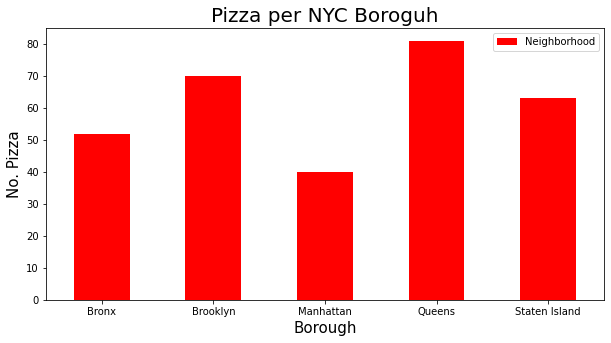

In [145]:
NYC_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color="red")
plt.title('Pizza Restaurants per NYC Boroguh', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.Pizza Restuarants in NYC',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Our analysis shows us that the number of pizza restaurants correlate with the amount of neighborhoods per borough

In [147]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
pizza_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in pizza_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(pizza_rest_ny),')','processed')
    pizza_rest_stats_ny = pizza_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
pizza_rest_stats_ny.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


In [149]:
pizza_rest_stats_ny.shape

(0, 7)

In [151]:
ny_neighborhood_stats=pizza_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Text(0, 0.5, 'Average Rating')

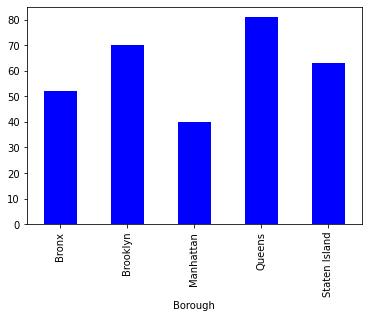

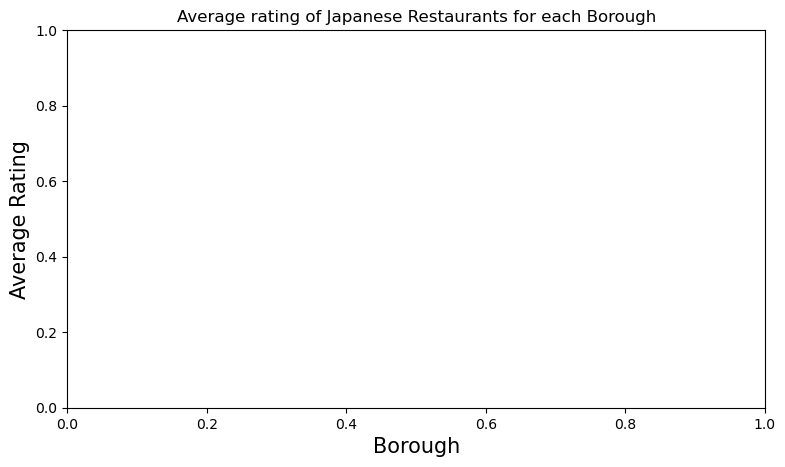

In [170]:
NYC_data.groupby('Borough')['Neighborhood'].count().plot(kind="bar", color = "blue")
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)


In [177]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'),zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in NYC_data[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [178]:
ny_map

## Results
From our results I've concluded that the Queens and the Bronx have the highest amount of pizza restaurants. Since Queens has the highest amount of neighborhoods this means that most of the bsiness need is met in Queens and therefore majority of the business need should acuatlly be considered in Brookyln since it is the second most populated with neighborhoods. This being said the type of pizza restuarant needs to be taken into consideration becuase of the demographic of Brookyln. 